# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 1
repeats = 5
importance_type = "split"

#first round of optimization
lgb_params = {
 "objective": "regression",
 'boosting_type': 'dart', 
 'metric': ['mae','mse', 'huber'],
 'lambda_l1': 0.03674546022666247, 
 'lambda_l2': 2.5025758383109715, 
 'max_leaves': 22,
 'max_depth': 6, 
 'feature_fraction': 0.741996402547356, 
 'bagging_fraction': 0.8929839112500518, 
 'learning_rate': 0.0892243160116563, 
 'min_data_in_leaf': 5, 
 'drop_rate': 0.14842616274718734    
}

debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/opt/miniconda3/envs/yspecies/lib/python38.zip', '/opt/miniconda3/envs/yspecies/lib/python3.8', '/opt/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/antonkulaga/.ipython']


In [3]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics
from yspecies.selection import ShapSelector
from yspecies.results import FeatureSummary

In [5]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: TkAgg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [6]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [7]:
data = ExpressionDataset.from_folder(locations.interim.selected)
data

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 12323)",12323,38,408,"(12323, 2)","(38, 19)"


## Setting up SHAP selection pipeline ##

Deciding on selection parameters (which fields to include, exclude, predict)

In [8]:
partition_params = PartitionParameters(n_folds, n_hold_out, 2, [],  42)


In [9]:
partition_shap_pipe = Pipeline([
    ("partitioner", DataPartitioner()),
    ('prepare_for_partitioning', TupleWith(lgb_params)),
    ("shap_computation", ShapSelector())
]
)
repeated_cv =  Repeat(partition_shap_pipe, repeats, lambda x,i: (x[0], replace(x[1], seed = i)))

In [10]:
selection_pipeline =  Pipeline(
    [
    ('extractor', DataExtractor()),
    ('prepare_for_partitioning', TupleWith(partition_params)), # to extract the data required for ML from the dataset
    ("partition_shap", repeated_cv),
    ("summarize", Collect(fold=lambda results: FeatureSummary(results)))
    ]
    )

## Setting up features to select ##

In [11]:
selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    clean_y_na = True,
    feature_perturbation = "tree_path_dependent"
)

#### Lifespan ####

In [13]:
select_mass = replace(selection, to_predict = "mass_g")
select_gestation = replace(selection, to_predict = "gestation")
select_mtgc = replace(selection, to_predict = "mtGC")

# First stage selection (shap ) #

In [14]:
select_lifespan_shap = replace(selection, select_by = "shap")
stage_one_lifespan_shap = selection_pipeline.fit_transform((data, select_lifespan_shap))
stage_one_lifespan_shap.selected

Early stopping is not available in dart mode


[150]	valid_0's l1: 23.9312	valid_0's l2: 2329.98	valid_0's huber: 21.1887
[150]	valid_0's l1: 4.65915	valid_0's l2: 67.8861	valid_0's huber: 3.85606
[150]	valid_0's l1: 2.84384	valid_0's l2: 24.0146	valid_0's huber: 2.23548
[150]	valid_0's l1: 3.72908	valid_0's l2: 41.9087	valid_0's huber: 3.02299
best iteration num 0, max evals 150
Fold 0 , best metrics: BasicMetrics(MAE=23.93123337547598, MSE=2329.977434856922, huber=21.188733204274943)
Fold 0 , last metrics: BasicMetrics(MAE=23.93123337547598, MSE=2329.977434856922, huber=21.188733204274943)
best iteration num 0, max evals 150
Fold 1 , best metrics: BasicMetrics(MAE=4.659151446520164, MSE=67.88612471567336, huber=3.856062038379995)
Fold 1 , last metrics: BasicMetrics(MAE=4.659151446520164, MSE=67.88612471567336, huber=3.856062038379995)
best iteration num 0, max evals 150
Fold 2 , best metrics: BasicMetrics(MAE=2.843836995124747, MSE=24.014552841853565, huber=2.23547878772887)
Fold 2 , last metrics: BasicMetrics(MAE=2.8438369951247

Early stopping is not available in dart mode


[150]	valid_0's l1: 3.31708	valid_0's l2: 37.0729	valid_0's huber: 2.64513
[150]	valid_0's l1: 4.62067	valid_0's l2: 73.3739	valid_0's huber: 3.81361
[150]	valid_0's l1: 3.6946	valid_0's l2: 36.2535	valid_0's huber: 2.99097
[150]	valid_0's l1: 21.8612	valid_0's l2: 2006	valid_0's huber: 19.3187
best iteration num 0, max evals 150
Fold 0 , best metrics: BasicMetrics(MAE=3.317078954405515, MSE=37.07285218240672, huber=2.645129788320993)
Fold 0 , last metrics: BasicMetrics(MAE=3.317078954405515, MSE=37.07285218240672, huber=2.645129788320993)
best iteration num 0, max evals 150
Fold 1 , best metrics: BasicMetrics(MAE=4.620667253951628, MSE=73.37389618876547, huber=3.813612258270608)
Fold 1 , last metrics: BasicMetrics(MAE=4.620667253951628, MSE=73.37389618876547, huber=3.813612258270608)
best iteration num 0, max evals 150
Fold 2 , best metrics: BasicMetrics(MAE=3.6946002708532584, MSE=36.253526550227804, huber=2.990969358076014)
Fold 2 , last metrics: BasicMetrics(MAE=3.6946002708532584,

Early stopping is not available in dart mode


[150]	valid_0's l1: 4.6456	valid_0's l2: 90.4933	valid_0's huber: 3.85759
[150]	valid_0's l1: 7.1214	valid_0's l2: 278.066	valid_0's huber: 6.08682
[150]	valid_0's l1: 5.52282	valid_0's l2: 83.7185	valid_0's huber: 4.67419
[150]	valid_0's l1: 6.0403	valid_0's l2: 131.537	valid_0's huber: 5.10838
best iteration num 0, max evals 150
Fold 0 , best metrics: BasicMetrics(MAE=4.645601904233411, MSE=90.49334687257871, huber=3.8575933992703346)
Fold 0 , last metrics: BasicMetrics(MAE=4.645601904233411, MSE=90.49334687257871, huber=3.8575933992703346)
best iteration num 0, max evals 150
Fold 1 , best metrics: BasicMetrics(MAE=7.12140070149021, MSE=278.06619214768955, huber=6.086820634760115)
Fold 1 , last metrics: BasicMetrics(MAE=7.12140070149021, MSE=278.06619214768955, huber=6.086820634760115)
best iteration num 0, max evals 150
Fold 2 , best metrics: BasicMetrics(MAE=5.522816245466056, MSE=83.71849835645652, huber=4.674194582689842)
Fold 2 , last metrics: BasicMetrics(MAE=5.522816245466056,

Early stopping is not available in dart mode


[150]	valid_0's l1: 2.8728	valid_0's l2: 20.8181	valid_0's huber: 2.2581
[150]	valid_0's l1: 25.1167	valid_0's l2: 2470.97	valid_0's huber: 22.2811
[150]	valid_0's l1: 3.3245	valid_0's l2: 30.2695	valid_0's huber: 2.67835
[150]	valid_0's l1: 9.7867	valid_0's l2: 203.252	valid_0's huber: 8.46325
best iteration num 0, max evals 150
Fold 0 , best metrics: BasicMetrics(MAE=2.8727954865738985, MSE=20.818110501815607, huber=2.2581006287932746)
Fold 0 , last metrics: BasicMetrics(MAE=2.8727954865738985, MSE=20.818110501815607, huber=2.2581006287932746)
best iteration num 0, max evals 150
Fold 1 , best metrics: BasicMetrics(MAE=25.11670855541735, MSE=2470.971777839441, huber=22.281097559973805)
Fold 1 , last metrics: BasicMetrics(MAE=25.11670855541735, MSE=2470.971777839441, huber=22.281097559973805)
best iteration num 0, max evals 150
Fold 2 , best metrics: BasicMetrics(MAE=3.3244965829468494, MSE=30.269508790628308, huber=2.6783526322239157)
Fold 2 , last metrics: BasicMetrics(MAE=3.32449658

Early stopping is not available in dart mode


[150]	valid_0's l1: 8.81106	valid_0's l2: 265.446	valid_0's huber: 7.57745
[150]	valid_0's l1: 2.56767	valid_0's l2: 16.5335	valid_0's huber: 1.9891
[150]	valid_0's l1: 3.32926	valid_0's l2: 31.636	valid_0's huber: 2.66257
[150]	valid_0's l1: 3.55625	valid_0's l2: 63.704	valid_0's huber: 2.87714
best iteration num 0, max evals 150
Fold 0 , best metrics: BasicMetrics(MAE=8.811059540624582, MSE=265.44564121349663, huber=7.5774538418950215)
Fold 0 , last metrics: BasicMetrics(MAE=8.811059540624582, MSE=265.44564121349663, huber=7.5774538418950215)
best iteration num 0, max evals 150
Fold 1 , best metrics: BasicMetrics(MAE=2.5676734549743605, MSE=16.533536972466816, huber=1.989097587058354)
Fold 1 , last metrics: BasicMetrics(MAE=2.5676734549743605, MSE=16.533536972466816, huber=1.989097587058354)
best iteration num 0, max evals 150
Fold 2 , best metrics: BasicMetrics(MAE=3.3292618360767112, MSE=31.63600229234912, huber=2.6625693278102887)
Fold 2 , last metrics: BasicMetrics(MAE=3.32926183

,symbol,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4
ensembl_id,,,,,,,,,,,
ENSG00000167515,TRAPPC2L,87.250,-0.209,50.000,-0.209,82.750,-0.274,96.750,-0.242,81.500,-0.269
ENSG00000105672,ETV2,81.750,0.708,57.750,0.666,61.000,0.679,68.000,0.690,77.500,0.672
ENSG00000142541,RPL13A,16.750,-0.060,27.000,-0.174,16.250,-0.203,17.000,0.190,13.250,-0.176
ENSG00000188747,NOXA1,13.250,0.702,2.250,0.675,6.250,0.711,5.500,0.697,5.500,0.657
ENSG00000136436,CALCOCO2,12.500,0.469,10.250,0.591,15.750,0.799,30.000,0.599,8.000,0.474
ENSG00000142002,DPP9,9.750,-0.497,7.500,-0.521,9.000,-0.479,8.000,-0.524,11.250,-0.488
ENSG00000189043,NDUFA4,6.750,-0.322,8.000,-0.500,8.250,-0.051,5.750,-0.289,6.500,-0.061


In [16]:
stage_one_lifespan_shap.metrics_average

Metrics(R2=0.618851577730441, MAE=7.56759560115024, MSE=415.1467436593989, huber=6.479287160368251)

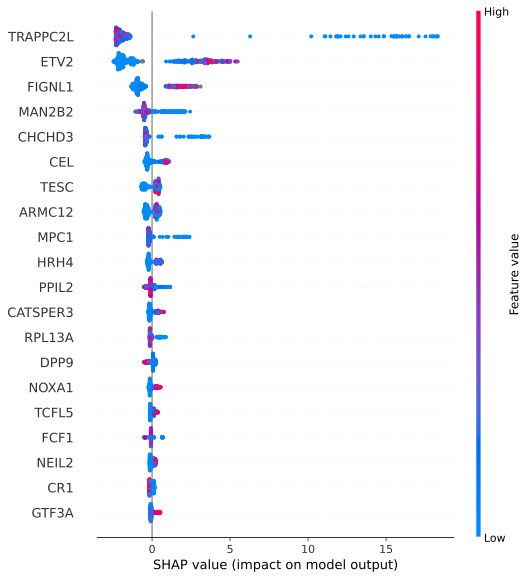

In [26]:
stage_one_lifespan_shap.results[4].plot()

In [17]:
stage_one_lifespan_shap.selected.symbol.values

array(['TRAPPC2L', 'ETV2', 'RPL13A', 'NOXA1', 'CALCOCO2', 'DPP9',
       'NDUFA4'], dtype=object)

In [17]:
stage_one_lifespan_shap.selected.symbol.values

array(['TRAPPC2L', 'ETV2', 'MAN2B2', 'RPL13A', 'TIMM8B', 'EFCAB11',
       'SMIM8', 'NDUFA4'], dtype=object)